In [23]:
using CLOUD.ConservationLaws
using CLOUD.SpatialDiscretizations
using CLOUD.Solvers
using CLOUD.InitialConditions
using CLOUD.Mesh
using CLOUD.IO
using OrdinaryDiffEq

"Set up paths"
plots_path = "../plots/advection1d_demo/"
results_path = "../results/advection1d_demo/"

"Define the physical problem"
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = 1*L/a  # end time

# constant-coefficient linear adection equation with sine wave initial condition
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a)
u_exact = initial_condition(initial_data, conservation_law)

"Set discretization parameters"
M = 10  # number of elements
p = 2  # degree of discretization
N_q = 3  # number of quadrature point
reference_approximation=ReferenceApproximation(DGSEM(p), 
    Line(), LGQuadrature())
form = StrongConservationForm()
dt_scale=0.1 

"Generate a uniform periodic mesh"
mesh = uniform_periodic_mesh(reference_approximation.reference_element, 
    (0.0,L), M)

"Construct spatial discretization"
spatial_discretization = SpatialDiscretization(mesh, reference_approximation)
    
ode_problem = semidiscretize(conservation_law, 
    spatial_discretization,
    initial_data, form,
    (0.0, T));

In [40]:
"run the solver"
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt_scale*(L/M)/(a*(2*p+1)), save_everystep=true);

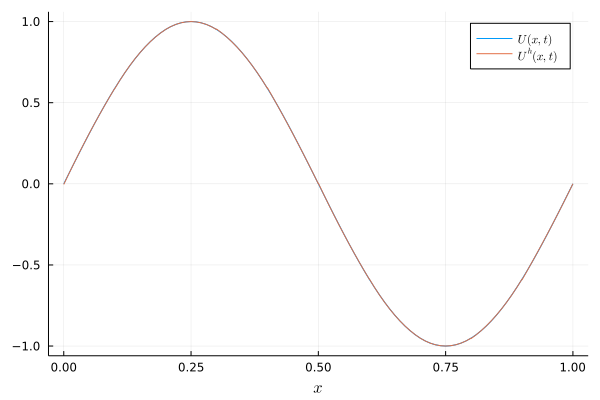

In [41]:
"visualize the solution"
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter,
    "final.pdf", exact_solution=u_exact,
     label="U^h(x,t)", label_exact="U(x,t)")

In [42]:
sol.u

39-element Vector{Array{Float64, 3}}:
 [0.07075337903774427; 0.30901699437494756; 0.5290714819166028]

[0.6435528540185771; 0.8090169943749475; 0.9268090192570828]

[0.9705370123213128; 1.0; 0.9705370123213127]

[0.9268090192570827; 0.8090169943749475; 0.6435528540185769]

[0.5290714819166026; 0.30901699437494795; 0.07075337903774401]

[-0.07075337903774377; -0.3090169943749469; -0.5290714819166028]

[-0.6435528540185771; -0.8090169943749468; -0.9268090192570825]

[-0.9705370123213126; -1.0; -0.9705370123213127]

[-0.9268090192570826; -0.8090169943749481; -0.6435528540185773]

[-0.5290714819166035; -0.3090169943749476; -0.07075337903774369]
 [-0.031220231830014128; 0.2106849334383527; 0.4384546366350581]

[0.5624144268046374; 0.7449932685843157; 0.8828772518179838]

[0.9412258901632075; 0.9947394965209495; 0.9900707647005395]

[0.9605210545708076; 0.8645290467385383; 0.7190908967350886]

[0.6129298230422519; 0.4040978853635523; 0.17344274721747527]

[0.031220231830014558; -0.2106849334